In [1]:
import sys
sys.path.append('../../../')
ver = 0

import sys
sys.path.append('../../../')
from data_tools.load_raw_cluster_data import LoadExperiment as le
from plot_tools.fig_preamble import *
from data_tools.data_risk_analysis import build_risk_dict, analyse_kalman_errs
from data_tools.data_tuned_run_analysis import TUNED_RUNS_DICT

datapath = '../../DATA_v'+str(ver)+'_/' 

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


In [2]:
###################################################################
# Load test case
###################################################################
test_case = 19
variation = 5

dataobject = le(test_case, variation, 
                skip = 1,
                GPRP_load='No', GPRP_path = './',
                LKFFB_load = 'Yes', LKFFB_path = datapath,
                AKF_load='Yes', AKF_path = datapath,
                LSF_load = 'No', LSF_path = './')

shape = dataobject.LKFFB_macro_truth.shape
macro_truth_full = dataobject.LKFFB_macro_truth.reshape(shape[0]*shape[1], shape[2])

AKF: Data Loaded? Yes
LKFFB: Data Loaded? Yes


In [3]:
###################################################################
# Generate a signal
###################################################################
pick_truth = int(np.random.uniform (low=0, high=shape[0]*shape[1]))
print("I picked", pick_truth)

noiseless_data = np.asarray(macro_truth_full[pick_truth,:])
noisy_data = noiseless_data
noisy_data += dataobject.LKFFB_msmt_noise_variance*np.random.normal(size=noiseless_data.shape[0])

sample_mean = np.mean(noisy_data)
sample_var = np.var(noisy_data)

print sample_mean,sample_var

('I picked', 1736)
-3.57621948248 726515.442423


In [4]:
###################################################################
# Calculate OLS parameters in 6.2.11
###################################################################

number_of_points = np.shape(noisy_data)[0]
J = int(number_of_points / 2.)# for even numbers
omega_0 = 2.0*np.pi/number_of_points
t_minus_1 = np.arange(number_of_points) 
omega_j = omega_0*np.arange(J) 

In [5]:
###################################################################
# Calculate OLS coefficents in 6.1.12 and 6.2.13
###################################################################

alpha_matrix = np.zeros((number_of_points, J))
beta_matrix = np.zeros((number_of_points, J))
# use of newaxis enables broadcasting
alpha_matrix = noisy_data[:, np.newaxis]*np.cos(np.outer(t_minus_1, np.arange(J))) 
beta_matrix = noisy_data[:, np.newaxis]*np.sin(np.outer(t_minus_1, np.arange(J)))
alpha_J = (2./number_of_points)*np.sum(alpha_matrix, axis=0)
beta_J = (2./number_of_points)*np.sum(beta_matrix, axis=0)

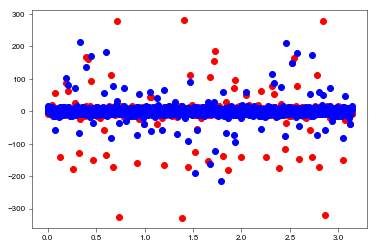

In [6]:
###################################################################
# Plot OLS coefficents 
###################################################################

plt.figure()
plt.plot(omega_j, alpha_J, 'ro')
plt.plot(omega_j, beta_J, 'bo')
plt.show()

In [7]:
###################################################################
# Make OLS Predictions according to 6.2.6
###################################################################

predictions = sample_mean + np.sum(alpha_J*np.cos(np.outer(t_minus_1, np.arange(J))), axis=1)
predictions +=np.sum(beta_J*np.sin(np.outer(t_minus_1, np.arange(J))), axis=1)

In [8]:
###################################################################
# Make AKF Prediction for Comparison
###################################################################
algo_type='AKF'

RISKDICT=build_risk_dict(dataobject)
opt_sigma, opt_R = analyse_kalman_errs(RISKDICT[algo_type][0],
                                       RISKDICT[algo_type][1],
                                       50)[2:]

KWGS = {'opt_sigma': opt_sigma[0], 'opt_R': opt_R[0]}
faxis, amp, thirdVar, pred_ = TUNED_RUNS_DICT[algo_type](dataobject, noisy_data, **KWGS)

I am in RISK DICT and test case and variations are: 19 5
Got here too
Total coeff 651.779417919 0.00014780310704


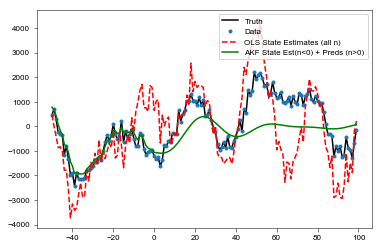

In [11]:
###################################################################
# Plot Results from OLS vs AKF
###################################################################


plt.figure()
plt.plot(range(-dataobject.Expt.n_testbefore, dataobject.Expt.n_predict, 1), 
         noiseless_data[1950:], 'k', label='Truth')
plt.plot(range(-dataobject.Expt.n_testbefore, dataobject.Expt.n_predict, 1), 
         noisy_data[1950:], '.', label='Data')
plt.plot(range(-dataobject.Expt.n_testbefore, dataobject.Expt.n_predict, 1), 
         predictions[1950:], 'r--', label='OLS State Estimates (all n)')
plt.plot(range(-dataobject.Expt.n_testbefore, dataobject.Expt.n_predict, 1), 
         pred_, 'g-', label='AKF State Est(n<0) + Preds (n>0)')
plt.legend(loc=1)
plt.show()